In [1]:
import pandas as pd
import time
import torch
import warnings
import seaborn as sns
import matplotlib.pyplot  as plt
from IPython import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f' Device: {torch.cuda.get_device_name(0)}. Now using: {device.type}', '\n',
      f'Torch Version: {torch.version.__version__}')

 Device: NVIDIA GeForce RTX 4070 Ti. Now using: cuda 
 Torch Version: 2.2.1


In [2]:
df = pd.read_csv('simpsons_script_lines(1).csv', low_memory=False)
phrases = df['normalized_text'].tolist()  # колонка с предобработанными текстами
text = [[c for c in ph] for ph in phrases if type(ph) is str]

In [3]:
CHARS = set('abcdefghijklmnopqrstuvwxyz ')
INDEX_TO_CHAR = ['none'] + [w for w in CHARS]
CHAR_TO_INDEX = {w: i for i, w in enumerate(INDEX_TO_CHAR)}

MAX_LEN = 75
X = torch.zeros((len(text), MAX_LEN), dtype=int)
for i in range(len(text)): 
    for j, w in enumerate(text[i]): 
        if j >= MAX_LEN:
            break
        X[i, j] = CHAR_TO_INDEX.get(w, CHAR_TO_INDEX['none'])

In [6]:
class CustomRnnCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRnnCell, self).__init__()
        self.hidden_size = hidden_size
        self.input_to_hidden = torch.nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden_state = torch.tanh(self.input_to_hidden(combined))
        return hidden_state

In [7]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.embedding = torch.nn.Embedding(28, 30)
        self.rnn_cell = CustomRnnCell(30, 128)
        self.out = torch.nn.Linear(128, 28)

    def forward(self, sentences, state=None):
        x = self.embedding(sentences)
        batch_size, sequence_length, _ = x.size()
        if state is None:
            state = torch.zeros(batch_size, 128).to(x.device)
        
        outputs = []
        for t in range(sequence_length):
            state = self.rnn_cell(x[:, t, :], state)
            outputs.append(state)
        
        outputs = torch.stack(outputs, dim=1)
        
        return self.out(outputs)

In [8]:
model = Network()
model.to(device)

Network(
  (embedding): Embedding(28, 30)
  (rnn_cell): CustomRnnCell(
    (input_to_hidden): Linear(in_features=158, out_features=128, bias=True)
  )
  (out): Linear(in_features=128, out_features=28, bias=True)
)

In [9]:
criterion = torch.nn.CrossEntropyLoss()  # типичный лосс многоклассовой классификации
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

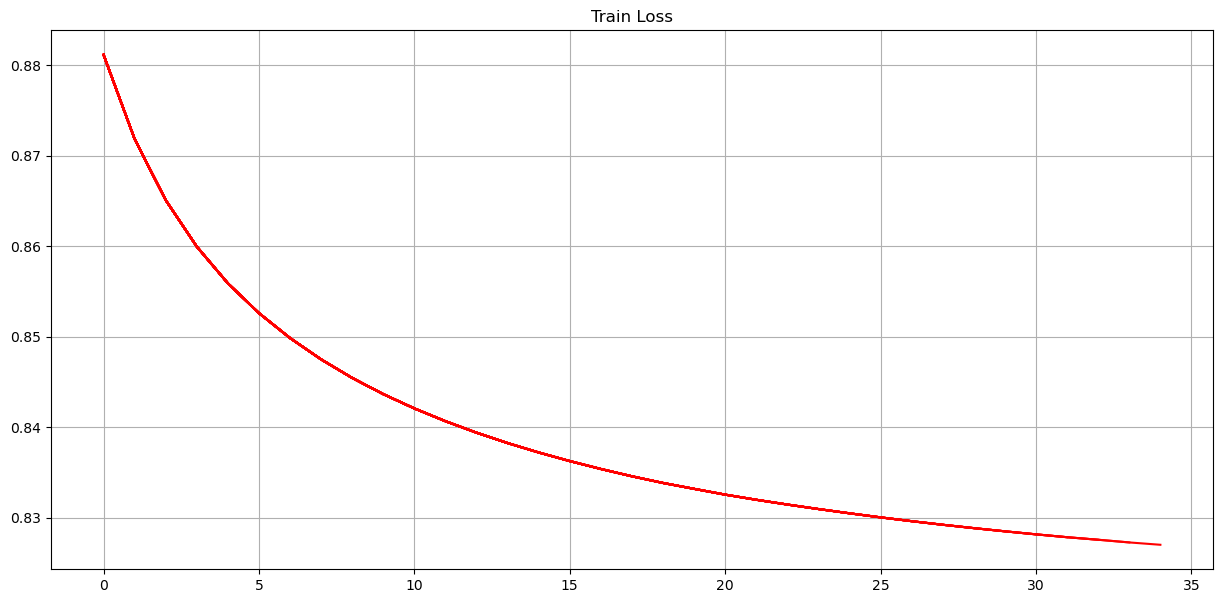

Epoch 34. Time: 42.514, Train loss: 0.827


In [12]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15, 7))
ax.grid()
ax.set_title('Train Loss')

losses = []
for ep in range(35):
    start = time.time()
    train_loss = 0.
    train_passed = 0

    for i in range(int(len(X) / 100)):
        # берём батч в 100 элементов
        batch = X[i * 100:(i + 1) * 100]
        X_batch = batch[:, :-1].to(device)
        Y_batch = batch[:, 1:].flatten().to(device)

        optimizer.zero_grad()
        answers = model.forward(X_batch)
        answers = answers.view(-1, len(INDEX_TO_CHAR))
        loss = criterion(answers, Y_batch)
        train_loss += loss.item()
        

        loss.backward()
        optimizer.step()
        train_passed += 1
    losses.append(train_loss / train_passed)
    sns.lineplot(losses, c='red', ax = ax)
    display.display(fig, clear=True)
    plt.close()

    print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, time.time() - start, train_loss / train_passed))

In [31]:
def generate_sentence(word):
    sentence = list(word)
    sentence = [CHAR_TO_INDEX.get(s, 0) for s in sentence]
    answers = model.forward(torch.tensor(sentence).unsqueeze(0).to(device))
    probas, indices = answers.topk(1)
    return ''.join([INDEX_TO_CHAR[ind.item()] for ind in indices.flatten()])

In [39]:
word = 'this is nonesense'
generate_sentence(word)


'hes is tote t t  '